In [27]:
import torch
import torch.nn as nn
from torch_geometric.data import Data
from numpy.linalg import eigh
from scipy.sparse.linalg import eigsh
from torch_geometric.utils import to_scipy_sparse_matrix
import copy

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import to_scipy_sparse_matrix
import numpy as np
import scipy.sparse as sp


# find device
if torch.cuda.is_available(): # NVIDIA
    device = torch.device('cuda')
elif torch.backends.mps.is_available(): # apple M1/M2
    device = torch.device('mps')
else:
    device = torch.device('cpu')
device

device(type='cuda')

# Task 1: Implement Laplacian Positional Encodings (LapPE)
 - Compute Laplacian eigenvectors using the graph Laplacian matrix `L = D - A`.
 - Use `eigh` for efficient eigendecomposition (optimized for Hermitian matrices).
 - Handle sign ambiguity in eigenvectors (random flipping or SignNet).
 - Ensure embeddings are robust to sign flips and can capture graph structure.

In [28]:

from scipy.sparse import csgraph


def compute_lap_pe(data, pe_dim=10, use_signnet=False):
    """
    Compute Laplacian Positional Encodings (LapPE) for a given graph data.

    Args:
        data (torch_geometric.data.Data): Graph data object.
        pe_dim (int): Number of eigenvectors to compute.
        use_signnet (bool): Whether to handle sign ambiguity using SignNet.

    Returns:
        data (torch_geometric.data.Data): Graph data object with 'lap_pe' attribute added.
    """
    num_nodes = data.num_nodes
    edge_index = data.edge_index

    # Convert to scipy sparse matrix
    adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes).astype(float)

    # Compute the Laplacian matrix
    laplacian = csgraph.laplacian(adj, normed=False)

    # For large sparse matrices, use eigsh
    try:
        # Compute the smallest k+1 eigenvalues and eigenvectors
        eigvals, eigvecs = eigsh(laplacian, k=pe_dim+1, which='SM')
        eigvecs = eigvecs[:, eigvals.argsort()]  # Sort eigenvectors
    except RuntimeError:
        # Fall back to dense computation for small graphs
        laplacian_dense = laplacian.toarray()
        eigvals, eigvecs = eigh(laplacian_dense)
        eigvecs = eigvecs[:, eigvals.argsort()]

    # Exclude the first eigenvector (corresponding to the smallest eigenvalue)
    pe = eigvecs[:, 1:pe_dim+1]

    # Handle sign ambiguity
    if use_signnet:
        # SignNet implementation (placeholder)
        # You would implement SignNet as a neural network layer in your model
        # For now, we'll assume the sign ambiguity is handled during model training
        pass
    else:
        # Randomly flip signs during training (data augmentation)
        # This helps the model to be robust to sign flips
        sign_flip = np.random.choice([-1, 1], size=(pe.shape[1],))
        pe = pe * sign_flip

    # Convert to torch tensor
    pe_tensor = torch.from_numpy(pe).float()

    # Add to data
    data.lap_pe = pe_tensor

    return data



Example

In [29]:

# Create a simple graph
# For this example, we'll create a graph with 5 nodes and some edges
edge_index = torch.tensor([
    [0, 1, 2, 3, 0, 2],
    [1, 2, 3, 4, 4, 0]
], dtype=torch.long)

# Create a Data object
data = Data(edge_index=edge_index)

# Set the number of nodes (important if some nodes have no edges)
data.num_nodes = 5

# Optionally, add node features (here we just use ones)
data.x = torch.ones((data.num_nodes, 1))

# Compute the Laplacian Positional Encodings
data = compute_lap_pe(data, pe_dim=3, use_signnet=False)

# Print the computed positional encodings
print("Laplacian Positional Encodings (lap_pe):")
print(data.lap_pe)



Laplacian Positional Encodings (lap_pe):
tensor([[-0.5407,  0.0073, -0.5276],
        [-0.4487,  0.0664,  0.7152],
        [ 0.4437, -0.0783, -0.3147],
        [ 0.4650,  0.6445,  0.2040],
        [-0.3052,  0.7577, -0.2636]])


# Task 2: Combine LapPE with SignNet
   - Implement SignNet to make the model sign-invariant.
   - Use SignNet to process the eigenvectors of the Laplacian to produce consistent embeddings.


In [30]:
import torch.nn as nn
import torch.nn.functional as F

class SignNet(nn.Module):
    """
    SignNet: A neural network that is invariant to the sign flips of input eigenvectors.
    """
    def __init__(self, in_dim, hidden_dim, out_dim, num_layers=2):
        super(SignNet, self).__init__()
        self.num_layers = num_layers
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(in_dim if _ == 0 else hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)
        self.out_layer = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        """
        Forward pass for SignNet.

        Args:
            x (torch.Tensor): Input eigenvectors of shape (num_nodes, in_dim)

        Returns:
            torch.Tensor: Sign-invariant embeddings of shape (num_nodes, out_dim)
        """
        x_pos = self.mlp(x)
        x_neg = self.mlp(-x)
        x = x_pos + x_neg
        x = self.out_layer(x)
        return x


def compute_lap_pe_with_signnet(data, pe_dim=10, hidden_dim=64, out_dim=32, num_layers=2):
    """
    Compute Laplacian Positional Encodings and process them with SignNet.

    Args:
        data (torch_geometric.data.Data): Graph data object.
        pe_dim (int): Number of eigenvectors to compute.
        hidden_dim (int): Hidden dimension for SignNet.
        out_dim (int): Output dimension for SignNet embeddings.
        num_layers (int): Number of layers in SignNet.

    Returns:
        data (torch_geometric.data.Data): Graph data object with 'sign_inv_lap_pe' attribute added.
    """
    num_nodes = data.num_nodes
    edge_index = data.edge_index

    # Convert to scipy sparse matrix
    from torch_geometric.utils import to_scipy_sparse_matrix
    import numpy as np
    from scipy.sparse import csgraph
    from scipy.sparse.linalg import eigsh
    from numpy.linalg import eigh

    adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes).astype(float)

    # Compute the Laplacian matrix
    laplacian = csgraph.laplacian(adj, normed=False)

    # For large sparse matrices, use eigsh
    try:
        eigvals, eigvecs = eigsh(laplacian, k=pe_dim+1, which='SM')
        eigvecs = eigvecs[:, eigvals.argsort()]  # Sort eigenvectors
    except RuntimeError:
        laplacian_dense = laplacian.toarray()
        eigvals, eigvecs = eigh(laplacian_dense)
        eigvecs = eigvecs[:, eigvals.argsort()]

    # Exclude the first eigenvector (corresponding to the smallest eigenvalue)
    pe = eigvecs[:, 1:pe_dim+1]

    # Convert to torch tensor
    pe_tensor = torch.from_numpy(pe).float()  # Shape: (num_nodes, pe_dim)

    # Initialize SignNet
    signnet = SignNet(in_dim=pe_dim, hidden_dim=hidden_dim, out_dim=out_dim, num_layers=num_layers)

    # Process the positional encodings with SignNet
    sign_inv_pe = signnet(pe_tensor)  # Shape: (num_nodes, out_dim)

    # Add to data
    data.lap_pe = sign_inv_pe

    return data


## Example


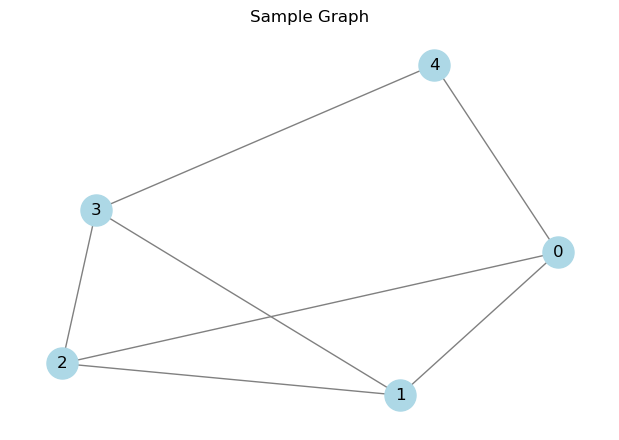

In [31]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a simple undirected graph
G = nx.Graph()
# Add nodes and edges
G.add_edges_from([
    (0, 1),
    (1, 2),
    (2, 3),
    (3, 4),
    (4, 0),
    (1, 3),
    (0, 2)
])

# Visualize the graph
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42)  # For consistent layout
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title("Sample Graph")
plt.show()


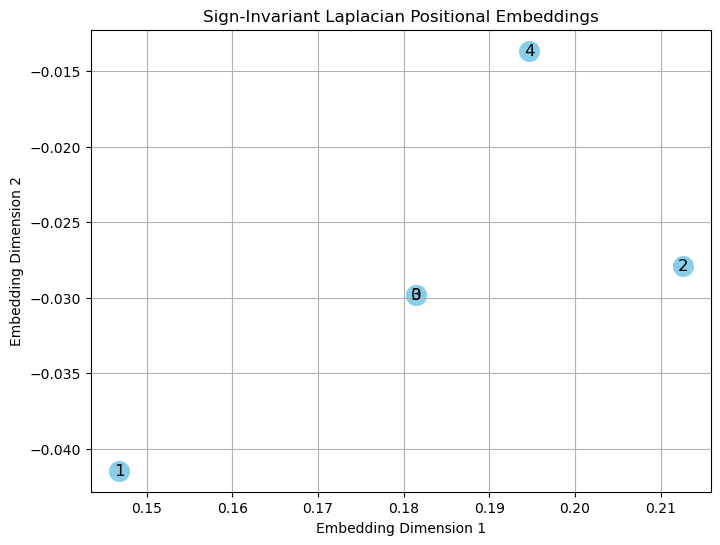

In [32]:
# Convert NetworkX graph to PyTorch Geometric data
from torch_geometric.utils import from_networkx

data = from_networkx(G)
# Ensure the number of nodes is set
data.num_nodes = G.number_of_nodes()

# Optionally, add dummy node features (e.g., ones)
data.x = torch.ones((data.num_nodes, 1))

# Set parameters
pe_dim = 3        # Number of eigenvectors to compute (excluding the first trivial one)
hidden_dim = 32    # Hidden dimension for SignNet
out_dim = 2        # Output dimension for embeddings (for 2D visualization)
num_layers = 2     # Number of layers in SignNet

# Compute sign-invariant Laplacian Positional Encodings
data = compute_lap_pe_with_signnet(data, pe_dim=pe_dim, hidden_dim=hidden_dim, out_dim=out_dim, num_layers=num_layers)

# Extract the embeddings
embeddings = data.lap_pe.detach().numpy()  # Convert to NumPy array for plotting

# Plot the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='skyblue', s=200)

# Annotate each point with the node index
for i, (x, y) in enumerate(embeddings):
    plt.text(x, y, str(i), fontsize=12, ha='center', va='center')

plt.title("Sign-Invariant Laplacian Positional Embeddings")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.grid(True)
plt.show()



# Task 3: Implement Random Walk Structural Embeddings (RWSE)
 - Compute RWSE by counting closed walks of a given length `k`:
   - Use the trace of powers of the adjacency matrix: `tr(A^2)`, `tr(A^3)`, ..., `tr(A^k)`.
   - Concatenate these trace values for embeddings.
 - Ensure efficient computation for larger graphs.
 - Compare RWSE with LapPE in terms of performance and computational cost.

In [33]:

def compute_rwse(data, K=5):
    """
    Compute Random Walk Structural Embeddings (RWSE) for a given graph data.

    Args:
        data (torch_geometric.data.Data): Graph data object.
        K (int): Maximum walk length.

    Returns:
        data (torch_geometric.data.Data): Graph data object with 'rwse' attribute added.
    """
    num_nodes = data.num_nodes
    edge_index = data.edge_index

    # Convert to scipy sparse matrix
    adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes).astype(float)
    adj = sp.csr_matrix(adj)

    # Initialize embeddings tensor
    rwse_embeddings = np.zeros((num_nodes, K - 1))

    # Start with A_power = adjacency matrix
    A_power = adj.copy()

    # For walk lengths from 2 to K
    for k in range(2, K + 1):
        # Multiply to get A^k
        A_power = A_power.dot(adj)

        # Get the diagonal entries
        diag_entries = A_power.diagonal()

        # Update embeddings
        rwse_embeddings[:, k - 2] = diag_entries

    # Optionally apply logarithmic scaling to handle large counts
    rwse_embeddings = np.log1p(rwse_embeddings)

    # Convert to torch tensor
    rwse_tensor = torch.from_numpy(rwse_embeddings).float()

    # Add to data
    data.rwse = rwse_tensor

    return data


RWSE Embeddings Shape: torch.Size([34, 2])
RWSE Embeddings:
tensor([[2.8332, 3.6109],
        [2.3026, 3.2189],
        [2.3979, 3.1355],
        [1.9459, 3.0445],
        [1.3863, 1.6094],
        [1.6094, 1.9459],
        [1.6094, 1.9459],
        [1.6094, 2.5649],
        [1.7918, 2.3979],
        [1.0986, 0.0000],
        [1.3863, 1.6094],
        [0.6931, 0.0000],
        [1.0986, 1.0986],
        [1.7918, 2.5649],
        [1.0986, 1.0986],
        [1.0986, 1.0986],
        [1.0986, 1.0986],
        [1.0986, 1.0986],
        [1.0986, 1.0986],
        [1.3863, 1.0986],
        [1.0986, 1.0986],
        [1.0986, 1.0986],
        [1.0986, 1.0986],
        [1.7918, 2.1972],
        [1.3863, 1.0986],
        [1.3863, 1.0986],
        [1.0986, 1.0986],
        [1.6094, 1.0986],
        [1.3863, 1.0986],
        [1.6094, 2.1972],
        [1.6094, 1.9459],
        [1.9459, 1.9459],
        [2.5649, 3.2958],
        [2.8904, 3.4340]])


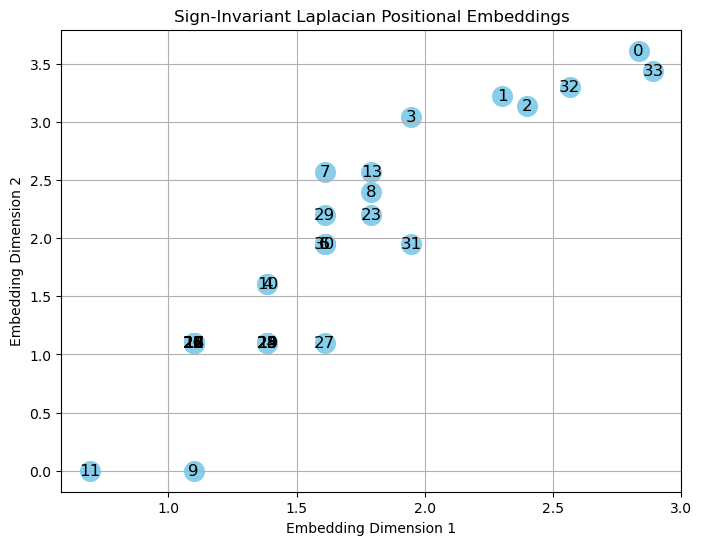

In [34]:
import torch
from torch_geometric.datasets import KarateClub

# Load sample dataset
dataset = KarateClub()
data = dataset[0]

# Compute RWSE embeddings
K = 3  # Maximum walk length
data = compute_rwse(data, K=K)

# Print RWSE embeddings
print("RWSE Embeddings Shape:", data.rwse.shape)
print("RWSE Embeddings:")
print(data.rwse)
embeddings = data.rwse.detach().numpy()

# Plot the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='skyblue', s=200)

# Annotate each point with the node index
for i, (x, y) in enumerate(embeddings):
    plt.text(x, y, str(i), fontsize=12, ha='center', va='center')

plt.title("Sign-Invariant Laplacian Positional Embeddings")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.grid(True)
plt.show()


# Task 4: Implement a Pure Graph Transformer
 - Treat nodes as tokens and apply a standard transformer model.
 - Use global attention to aggregate information across all nodes.
 - Start with node labels as initial embeddings and incorporate LapPE and RWSE.
 - Implement and test the transformer to evaluate its ability to capture graph structure.


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid  # For Cora dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
import math

In [36]:

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x



class GraphTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(GraphTransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        # src shape: (N, batch_size, d_model)
        src2 = self.self_attn(src, src, src)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)

        src2 = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src



class GraphTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=3, nhead=8, dropout=0.1):
        super(GraphTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.position_embedding = nn.Parameter(torch.zeros(1, hidden_dim))
        self.layers = nn.ModuleList([
            GraphTransformerEncoderLayer(hidden_dim, nhead, hidden_dim * 4, dropout)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: (num_nodes, input_dim)
        x = self.embedding(x)  # (num_nodes, hidden_dim)
        x = x.unsqueeze(1)  # (num_nodes, batch_size=1, hidden_dim)

        # Add position embedding if needed (already included via LapPE and RWSE)
        # x = x + self.position_embedding

        x = x.transpose(0, 1)  # (batch_size=1, num_nodes, hidden_dim)

        for layer in self.layers:
            x = layer(x)

        x = x.transpose(0, 1)  # (num_nodes, batch_size=1, hidden_dim)
        x = x.squeeze(1)       # (num_nodes, hidden_dim)

        # For node classification: output per node
        out = self.classifier(self.dropout(x))  # (num_nodes, num_classes)
        return out


In [37]:
def train(model, optimizer, data, criterion):
    model = model.to(data.x.device)
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index) if isinstance(model, GCN) else model(data.x)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def test(model, data):
    model.eval()
    logits = model(data.x)
    masks = ['train_mask', 'val_mask', 'test_mask']
    accuracies = []
    for mask in masks:
        mask = getattr(data, mask)
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accuracies.append(acc)
    return accuracies

def evaluate(model, data):
    model.eval()
    logits = model(data.x, data.edge_index) if isinstance(model, GCN) else model(data.x)
    masks = ['train_mask', 'val_mask', 'test_mask']
    accuracies = []
    for mask_name in masks:
        mask = getattr(data, mask_name)
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accuracies.append(acc)
    return accuracies  # Returns [train_acc, val_acc, test_acc]



In [38]:
# Load the dataset (e.g., Cora)
dataset = Planetoid(root='dataset/Cora', name='Cora')
data = dataset[0]

# Compute LapPE and RWSE
data = compute_lap_pe(data, pe_dim=10)
data = compute_rwse(data, K=5)

# Concatenate node features
data.x = torch.cat([data.x, data.lap_pe, data.rwse], dim=-1)
data = data.to(device)


# Model parameters
input_dim = data.x.shape[1]
hidden_dim = 64
num_classes = dataset.num_classes
num_layers = 3
nhead = 8
dropout = 0.1

model = GraphTransformer(input_dim, hidden_dim, num_classes, num_layers, nhead, dropout)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 200
for epoch in range(1, num_epochs + 1):
    loss = train(model,optimizer , data, criterion)
    train_acc, val_acc, test_acc = test(model, data)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 10, Loss: 0.0689, Train Acc: 1.0000, Val Acc: 0.4820, Test Acc: 0.4910
Epoch: 20, Loss: 0.0214, Train Acc: 1.0000, Val Acc: 0.4960, Test Acc: 0.4930
Epoch: 30, Loss: 0.0089, Train Acc: 1.0000, Val Acc: 0.4860, Test Acc: 0.4810
Epoch: 40, Loss: 0.0049, Train Acc: 1.0000, Val Acc: 0.4960, Test Acc: 0.4920
Epoch: 50, Loss: 0.0036, Train Acc: 1.0000, Val Acc: 0.4960, Test Acc: 0.4950
Epoch: 60, Loss: 0.0027, Train Acc: 1.0000, Val Acc: 0.4980, Test Acc: 0.4990
Epoch: 70, Loss: 0.0024, Train Acc: 1.0000, Val Acc: 0.5060, Test Acc: 0.4980
Epoch: 80, Loss: 0.0018, Train Acc: 1.0000, Val Acc: 0.5040, Test Acc: 0.4980
Epoch: 90, Loss: 0.0015, Train Acc: 1.0000, Val Acc: 0.5040, Test Acc: 0.4980
Epoch: 100, Loss: 0.0016, Train Acc: 1.0000, Val Acc: 0.5040, Test Acc: 0.4970
Epoch: 110, Loss: 0.0013, Train Acc: 1.0000, Val Acc: 0.5040, Test Acc: 0.4990
Epoch: 120, Loss: 0.0012, Train Acc: 1.0000, Val Acc: 0.5040, Test Acc: 0.5020
Epoch: 130, Loss: 0.0009, Train Acc: 1.0000, Val Acc: 0.5080,


 #  Task 5: Test the Performance of LapPE and RWSE Embeddings
 - Test LapPE and RWSE embeddings with:
   - A Graph Neural Network (GNN) model.
   - The pure Graph Transformer implemented above.
 - Compare results to understand how the embeddings impact performance.

## Task 6: Test on Datasets
 - Use the following datasets for training and evaluation:
   1. **Peptides-func**:
      - Apply an atom-encoder to represent nodes (atoms in molecules).
      - Combine the atom-encoder embeddings with LapPE and RWSE.
   2. **Cora**:
      - Test embeddings and transformer performance on this graph dataset.





In [39]:
def run_experiments(data, model_type='gnn', epochs=200):
    
    results = []
    data = data.to(device)
    for config in configs:
        exp_data = copy.deepcopy(data)
        exp_data = exp_data.to(device)

        # Compute LapPE with SignNet
        features = [exp_data.x.to(device)]  # Ensure the base feature tensor is on the GPU
        if config['use_lappe']:
            features.append(exp_data.lap_pe.to(device))  # Move LapPE to the GPU
        if config['use_rwse']:
            features.append(exp_data.rwse.to(device))  # Move RWSE to the GPU
        exp_data.x = torch.cat(features, dim=-1)  # Concatenate all tensors

    
        # Compute RWSE
        features = [exp_data.x.to(device)]
        if config['use_rwse']:
            exp_data = compute_rwse(exp_data, K=5)
            rwse_dim = exp_data.rwse.shape[1]
        else:
            rwse_dim = 0

        # Combine features
        features = [exp_data.x.to(device)]  # Ensure the base feature tensor is on the GPU
        if config['use_lappe']:
            features.append(exp_data.lap_pe.to(device))  # Move LapPE to the GPU
        if config['use_rwse']:
            features.append(exp_data.rwse.to(device))  # Move RWSE to the GPU

        # Ensure all features are on the same device
        features = [f.to(device) for f in features]
        exp_data.x = torch.cat(features, dim=-1)  # Concatenate all tensors


        # Initialize model
        input_dim = exp_data.x.shape[1]
        hidden_dim = 64
        num_classes = dataset.num_classes

        if model_type == 'gnn':
            model = GCN(input_dim, hidden_dim, num_classes)
        elif model_type == 'transformer':
            model = GraphTransformer(input_dim, hidden_dim, num_classes, num_layers=3)
        else:
            raise ValueError("Invalid model_type: Choose 'gnn' or 'transformer'.")

        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()
        model = model.to(device)

        # Train and evaluate
        for epoch in range(1, epochs):
            loss = train(model, optimizer, exp_data, criterion)
            train_acc, val_acc, test_acc = evaluate(model, exp_data)
            if epoch % 20 == 0:
                print(f"[{config['name']}] Epoch {epoch}, Loss: {loss:.4f}, Train: {train_acc:.4f}, "
                      f"Val: {val_acc:.4f}, Test: {test_acc:.4f}")

        results.append({
            'config': config['name'],
            'train_acc': train_acc,
            'val_acc': val_acc,
            'test_acc': test_acc,
        })

    return results


In [40]:
configs = [
    {'name': 'Baseline', 'use_lappe': False, 'use_rwse': False},
    {'name': 'LapPE', 'use_lappe': True, 'use_rwse': False},
    {'name': 'RWSE', 'use_lappe': False, 'use_rwse': True},
    {'name': 'LapPE + RWSE', 'use_lappe': True, 'use_rwse': True},
]


In [41]:
results_gnn = run_experiments(data, model_type='gnn')


[Baseline] Epoch 20, Loss: 0.0068, Train: 1.0000, Val: 0.7680, Test: 0.7930
[Baseline] Epoch 40, Loss: 0.0045, Train: 1.0000, Val: 0.7780, Test: 0.7980
[Baseline] Epoch 60, Loss: 0.0116, Train: 1.0000, Val: 0.7740, Test: 0.8090
[Baseline] Epoch 80, Loss: 0.0100, Train: 1.0000, Val: 0.7700, Test: 0.8050
[Baseline] Epoch 100, Loss: 0.0088, Train: 1.0000, Val: 0.7740, Test: 0.8040
[Baseline] Epoch 120, Loss: 0.0081, Train: 1.0000, Val: 0.7720, Test: 0.8050
[Baseline] Epoch 140, Loss: 0.0076, Train: 1.0000, Val: 0.7720, Test: 0.8050
[Baseline] Epoch 160, Loss: 0.0072, Train: 1.0000, Val: 0.7800, Test: 0.8030
[Baseline] Epoch 180, Loss: 0.0069, Train: 1.0000, Val: 0.7760, Test: 0.8040
[LapPE] Epoch 20, Loss: 0.0079, Train: 1.0000, Val: 0.7840, Test: 0.7960
[LapPE] Epoch 40, Loss: 0.0048, Train: 1.0000, Val: 0.7800, Test: 0.8070
[LapPE] Epoch 60, Loss: 0.0124, Train: 1.0000, Val: 0.7760, Test: 0.8060
[LapPE] Epoch 80, Loss: 0.0108, Train: 1.0000, Val: 0.7720, Test: 0.8050
[LapPE] Epoch 100, 

In [42]:
# Run experiments with Transformer
results_transformer = run_experiments(data, model_type='transformer', epochs=500)

[Baseline] Epoch 20, Loss: 0.0341, Train: 1.0000, Val: 0.4520, Test: 0.4880
[Baseline] Epoch 40, Loss: 0.0042, Train: 1.0000, Val: 0.4700, Test: 0.5050
[Baseline] Epoch 60, Loss: 0.0021, Train: 1.0000, Val: 0.4880, Test: 0.5280
[Baseline] Epoch 80, Loss: 0.0016, Train: 1.0000, Val: 0.4840, Test: 0.5270
[Baseline] Epoch 100, Loss: 0.0016, Train: 1.0000, Val: 0.4980, Test: 0.5300
[Baseline] Epoch 120, Loss: 0.0018, Train: 1.0000, Val: 0.5140, Test: 0.5290
[Baseline] Epoch 140, Loss: 0.0015, Train: 1.0000, Val: 0.5160, Test: 0.5320
[Baseline] Epoch 160, Loss: 0.0021, Train: 1.0000, Val: 0.5360, Test: 0.5390
[Baseline] Epoch 180, Loss: 0.0019, Train: 1.0000, Val: 0.5400, Test: 0.5510
[Baseline] Epoch 200, Loss: 0.0018, Train: 1.0000, Val: 0.5380, Test: 0.5510
[Baseline] Epoch 220, Loss: 0.0018, Train: 1.0000, Val: 0.5380, Test: 0.5450
[Baseline] Epoch 240, Loss: 0.0019, Train: 1.0000, Val: 0.5220, Test: 0.5380
[Baseline] Epoch 260, Loss: 0.0014, Train: 1.0000, Val: 0.5200, Test: 0.5390
[Ba

# Implement and Test on the Peptides-func Dataset

In [43]:
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNGraphLevel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GCNGraphLevel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.pool = global_mean_pool
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch

        x = atom_encoder(x)  # Use AtomEncoder
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.pool(x, batch)
        x = self.classifier(x)
        return x
    
class GraphTransformerGraphLevel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=3, nhead=8, dropout=0.1):
        super(GraphTransformerGraphLevel, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.layers = nn.ModuleList([
            GraphTransformerEncoderLayer(hidden_dim, nhead, hidden_dim * 4, dropout)
            for _ in range(num_layers)
        ])
        self.pool = global_mean_pool
        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch

        x = atom_encoder(x)  # Use AtomEncoder
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = x.transpose(0, 1)

        for layer in self.layers:
            x = layer(x)

        x = x.transpose(0, 1).squeeze(1)
        x = self.pool(x, batch)
        x = self.classifier(self.dropout(x))
        return x

def preprocess_dataset(dataset, pe_dim=10, K=5, use_signnet=False):
    for data in dataset:
        # Compute LapPE
        if use_signnet:
            data = compute_lap_pe_with_signnet(data, pe_dim=pe_dim)
        else:
            data = compute_lap_pe(data, pe_dim=pe_dim)

        # Compute RWSE
        data = compute_rwse(data, K=K)

        # Concatenate features
        x_list = [atom_encoder(data.x)]
        x_list.append(data.lap_pe)
        x_list.append(data.rwse)
        data.x = torch.cat(x_list, dim=-1)
    return dataset

def train_graph_level(model, optimizer, loader, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def evaluate_graph_level(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y.view(-1)).sum().item()
            total += data.num_graphs
    return correct / total



In [44]:
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.loader import DataLoader
from ogb.graphproppred.mol_encoder import AtomEncoder

# Load the Peptides-func dataset
dataset_peptides = PygGraphPropPredDataset(name='ogbg-molpcba')

# Split the dataset
split_idx = dataset_peptides.get_idx_split()
train_dataset = dataset_peptides[split_idx['train']]
valid_dataset = dataset_peptides[split_idx['valid']]
test_dataset = dataset_peptides[split_idx['test']]

atom_encoder = AtomEncoder(emb_dim=64)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


train_dataset = preprocess_dataset(train_dataset, pe_dim=10, K=1, use_signnet=True)
valid_dataset = preprocess_dataset(valid_dataset, pe_dim=10, K=1, use_signnet=True)
test_dataset = preprocess_dataset(test_dataset, pe_dim=10, K=1, use_signnet=True)


C:\ProgramData\miniconda3\Lib\site-packages\ogb\graphproppred\dataset_pyg.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.proce

TypeError: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.

In [45]:
# Initialize model
input_dim = train_dataset[0].x.shape[1]
hidden_dim = 64
num_classes = dataset_peptides.num_tasks  # Adjust as per dataset

input_dim = data.x.shape[1]  # Automatically adjust to the number of features
model = GCNGraphLevel(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=dataset.num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()  # For multi-label classification

# Training loop
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    train_loss = train_graph_level(model, optimizer, train_loader, criterion)
    train_acc = evaluate_graph_level(model, train_loader)
    val_acc = evaluate_graph_level(model, valid_loader)
    test_acc = evaluate_graph_level(model, test_loader)
    print(f"Epoch {epoch}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (821x64 and 1447x64)